<a href="https://colab.research.google.com/github/pranjaldatta/SSIM-PyTorch/blob/master/SSIM_notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch  
import torch.nn.functional as F 
import numpy as np
import math
from PIL import Image
import cv2
from google.colab.patches import cv2_imshow

In [2]:
!git clone https://github.com/pranjaldatta/SSIM-PyTorch.git

Cloning into 'SSIM-PyTorch'...
remote: Enumerating objects: 13, done.
remote: Counting objects: 100% (13/13), done.
remote: Compressing objects: 100% (11/11), done.
remote: Total 13 (delta 2), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (13/13), done.


In [3]:
def gaussian(window_size, sigma):
    """
    Generates a list of Tensor values drawn from a gaussian distribution with standard
    diviation = sigma and sum of all elements = 1.

    Length of list = window_size
    """    
    gauss =  torch.Tensor([math.exp(-(x - window_size//2)**2/float(2*sigma**2)) for x in range(window_size)])
    return gauss/gauss.sum()

In [4]:
gauss_dis = gaussian(11, 1.5)
print("Distribution: ", gauss_dis)
print("Sum of Gauss Distribution:", torch.sum(gauss_dis))

Distribution:  tensor([0.0010, 0.0076, 0.0360, 0.1094, 0.2130, 0.2660, 0.2130, 0.1094, 0.0360,
        0.0076, 0.0010])
Sum of Gauss Distribution: tensor(1.)


In [5]:
def create_window(window_size, channel=1):

    # Generate an 1D tensor containing values sampled from a gaussian distribution
    _1d_window = gaussian(window_size=window_size, sigma=1.5).unsqueeze(1)
    
    # Converting to 2D  
    _2d_window = _1d_window.mm(_1d_window.t()).float().unsqueeze(0).unsqueeze(0)
     
    window = torch.Tensor(_2d_window.expand(channel, 1, window_size, window_size).contiguous())

    return window



In [6]:
window = create_window(11, 3)
print("Shape of gaussian window:", window.shape)

Shape of gaussian window: torch.Size([3, 1, 11, 11])


In [7]:
def ssim(img1, img2, val_range, window_size=11, window=None, size_average=True, full=False):

    L = val_range # L is the dynamic range of the pixel values (255 for 8-bit grayscale images),

    pad = window_size // 2
    
    try:
        _, channels, height, width = img1.size()
    except:
        channels, height, width = img1.size()

    # if window is not provided, init one
    if window is None: 
        real_size = min(window_size, height, width) # window should be atleast 11x11 
        window = create_window(real_size, channel=channels).to(img1.device)
    
    # calculating the mu parameter (locally) for both images using a gaussian filter 
    # calculates the luminosity params
    mu1 = F.conv2d(img1, window, padding=pad, groups=channels)
    mu2 = F.conv2d(img2, window, padding=pad, groups=channels)
    
    mu1_sq = mu1 ** 2
    mu2_sq = mu2 ** 2 
    mu12 = mu1 * mu2

    # now we calculate the sigma square parameter
    # Sigma deals with the contrast component 
    sigma1_sq = F.conv2d(img1 * img1, window, padding=pad, groups=channels) - mu1_sq
    sigma2_sq = F.conv2d(img2 * img2, window, padding=pad, groups=channels) - mu2_sq
    sigma12 =  F.conv2d(img1 * img2, window, padding=pad, groups=channels) - mu12

    # Some constants for stability 
    C1 = (0.01 ) ** 2  # NOTE: Removed L from here (ref PT implementation)
    C2 = (0.03 ) ** 2 

    contrast_metric = (2.0 * sigma12 + C2) / (sigma1_sq + sigma2_sq + C2)
    contrast_metric = torch.mean(contrast_metric)

    numerator1 = 2 * mu12 + C1  
    numerator2 = 2 * sigma12 + C2
    denominator1 = mu1_sq + mu2_sq + C1 
    denominator2 = sigma1_sq + sigma2_sq + C2

    ssim_score = (numerator1 * numerator2) / (denominator1 * denominator2)

    if size_average:
        ret = ssim_score.mean() 
    else: 
        ret = ssim_score.mean(1).mean(1).mean(1)
    
    if full:
        return ret, contrast_metric
    
    return ret


In [8]:
# helper function to load images
load_images = lambda x: np.asarray(Image.open(x).resize((480, 640)))

# Helper functions to convert to Tensors
tensorify = lambda x: torch.Tensor(x.transpose((2, 0, 1))).unsqueeze(0).float().div(255.0)

# display imgs 
def display_imgs(x, transpose=True, resize=True):
  if resize:
    x=cv2.resize(x, (400, 400))
  if transpose:
    cv2_imshow(cv2.cvtColor(x, cv2.COLOR_BGR2RGB))
  else:
    cv2_imshow(x)

True Image



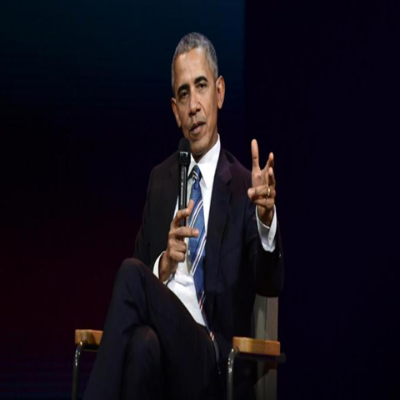


False Image



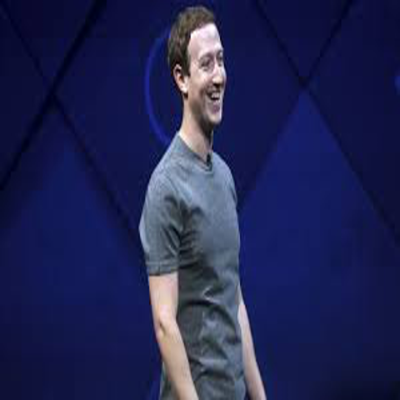


Noised True Image



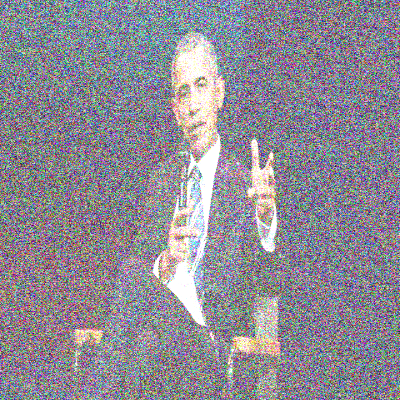

In [9]:
# The true reference Image 
img1 = load_images("SSIM-PyTorch/obamatest6.jpg")

# The False image
img2 = load_images("SSIM-PyTorch/zucktest3.jpeg")

# The noised true image
noise = np.random.randint(0, 255, (640, 480, 3)).astype(np.float32)
noisy_img = img1 + noise 

print("True Image\n")
display_imgs(img1)

print("\nFalse Image\n")
display_imgs(img2)

print("\nNoised True Image\n")
display_imgs(noisy_img)


In [10]:
# Check SSIM score of True image vs False Image
_img1 = tensorify(img1)
_img2 = tensorify(img2)
true_vs_false = ssim(_img1, _img2, val_range=255)
print("True vs False Image SSIM Score:", true_vs_false)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  """


True vs False Image SSIM Score: tensor(0.3385)


In [11]:
# Check SSIM score of True image vs Noised_true Image
_img1 = tensorify(img1)
_img2 = tensorify(noisy_img)
true_vs_false = ssim(_img1, _img2, val_range=255)
print("True vs Noisy True Image SSIM Score:", true_vs_false)

True vs Noisy True Image SSIM Score: tensor(0.0184)


In [12]:
# Check SSIM score of True image vs True Image
_img1 = tensorify(img1)
true_vs_false = ssim(_img1, _img1, val_range=255)
print("True vs True Image SSIM Score:", true_vs_false)

True vs True Image SSIM Score: tensor(1.)
